# 2. Data wrangling & cleaning

## 2.1 Import libraries, options and reading data.

In [1]:
import pandas as pd
import regex as re
import numpy as np
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
cars = pd.concat([pd.read_csv('./data/madrid.csv'),pd.read_csv('./data/barcelona.csv')],axis=0).reset_index(drop=True)

## 2.2 Duplicates & inconsistent data

In [3]:
# Dropping duplicates of column ID.
cars = cars.drop_duplicates(subset=['id']).reset_index(drop=True)
# 7560603 is an example of a duplicated car. 

In [4]:
# Dropping unique identifiers and repeated columns.
cars = cars.drop(['id','link','transmission','warranty','seller','autonomy'], axis=1)
# I also drop 'Autonomy', 'Warranty', 'Seller' and 'Autonomy' because they have no variance.

## 2.3 Formatting numerical features

In [5]:
# 'Nuevo' stands for 'New' in spanish. They are not second-hand cars and thus do not belong into our model.
cars = cars[cars['km']!='NUEVO'].copy()

In [6]:
# Using regex (Regular expression) to remove units and text.
cars['cv'] = cars['cv'].map(lambda x: re.findall(r'\d+',x)[0])
cars['km'] = cars['km'].map(lambda x: re.findall(r'\d*', x.replace('.',''))[0])
cars['doors'] = cars['doors'].map(lambda x: re.findall(r'\d+',x)[0])
cars['emissions'] = cars['emissions'].map(lambda x: re.findall(r'\d+',x)[0])

# Computing the age of each car.
cars['year'] = (datetime.date.today().year - pd.to_datetime(cars['year']).dt.year)

# Correcting some formats to numerical.
cars['cv'] = pd.to_numeric(cars['cv'], errors='coerce')
cars['km'] = pd.to_numeric(cars['km'], errors='coerce')
cars['doors'] = pd.to_numeric(cars['doors'], errors='coerce')
cars['emissions'] = pd.to_numeric(cars['emissions'], errors='coerce')

In [7]:
# There is a small but significant amount of inconsistent data. Some cars were 
# posted without all of its features listed, and the web print those as the number 0. 
# None of the features are compatible with zero value (it makes no sense to have a max
# speed of 0, 0 seats, etc). There are two exceptions (years and marchas), but we are
# those only affect to either brand new or electric cars, which fall outside of our scope.

# Summing up: we remove any row that has a null feature. 
cars = cars[(cars!=0).all(axis=1)].reset_index(drop=True)

## 2.3 Unifying categorical values

In [8]:
# Values to lowercase
for column in cars.select_dtypes(object).columns:
    cars[column] = cars[column].str.lower()

In [9]:
def clean_color(car):
    if 'blanco' in car:
        return 'blanco'
    elif 'negro' in car:
        return 'negro'
    elif 'gris' in car:
        return 'gris'
    elif ('marrón' in car)|('marron' in car):
        return 'marron'
    elif 'azul' in car:
        return 'azul'
    elif ('rojo' in car)|('granate' in car):
        return 'rojo'
    elif ('plateado' in car)|('plata' in car):
        return 'plateado'
    elif 'verde' in car:
        return 'verde'
    elif 'naranja' in car:
        return 'naranja'
    elif ('amarillo' in car)|('oro' in car):
        return 'amarillo'
    elif 'beige' in car:
        return 'beige'
    else:
        return 'otros'
    
def clean_cilindros(car):
    n = int(re.findall(r'\d+',car)[0])
    if 'en línea' in car:
        if n == 4:
            return '4 inline'
        elif n<4:
            return 'more4 inline'
        elif n>4:
            return 'less4 inline'
    elif 'en v' in car:
        if n == 6:
            return '6 V'
        else:
            return 'more6 V'
    elif 'en boxer' in car:
        return 'boxer'
    else:
        return 'other'
    
def clean_gearbox(car):
    if 'manual' in car:
        return 'manual'
    else:
        return 'automatic'

In [10]:
# Some cars have no information about their color (NaN).
cars = cars[~cars['color'].isna()].copy() # They are a small %, I remove them.

# Unifying categories.
cars['color']=cars['color'].map(clean_color)
cars['gearbox']=cars['gearbox'].map(clean_gearbox)
cars['cilindros'] = cars['cilindros'].map(clean_cilindros)

# Combining brands with a count smaller than <threshold> into "other".
threshold = 9
other_brands = cars['brand'].value_counts()[cars['brand'].value_counts().values<threshold].index
cars['brand'] = np.where(cars['brand'].isin(other_brands), 'other',cars['brand'])

In [11]:
cars.head(5)

,year,cv,km,fuel,doors,gearbox,emissions,color,brand,price,boot,length,height,width,seats,max_sp,cmixto,curban,extraurban,0-100,cilindrada,cilindros,max_par,marchas,class,location
0,6,85,38300,gasolina,5,manual,114,gris,ford,8890,272,393,152,170,5,168,4.9,6.5,3.9,13.6,1242,4 inline,112,5,common,madrid
1,16,140,224820,diesel,4,manual,148,gris,honda,4990,459,467,145,176,5,212,5.5,7.2,4.5,9.3,2204,4 inline,340,6,common,madrid
2,4,100,40139,diesel,5,manual,112,blanco,citroen,18990,775,440,184,185,5,175,4.0,4.8,4.0,12.3,1499,4 inline,250,5,common,madrid
3,14,105,217000,diesel,5,manual,135,gris,renault,4200,564,456,165,185,7,180,5.3,6.5,4.6,13.4,1461,4 inline,240,6,common,madrid
4,8,130,128211,gasolina,5,manual,123,blanco,peugeot,10990,432,437,163,184,5,199,5.3,6.5,4.6,10.8,1199,more4 inline,230,6,common,madrid


## 2.5 Target correlation 

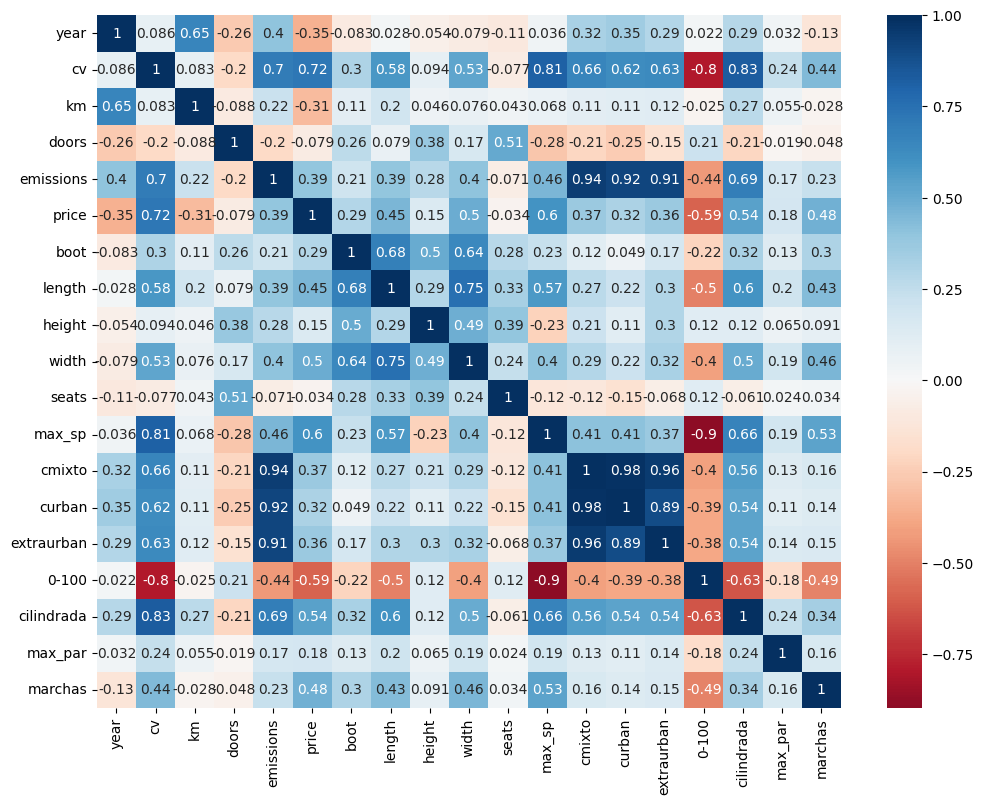

In [12]:
plt.figure(figsize=(12,9))
sns.heatmap(cars.select_dtypes(np.number).corr(), annot=True, cmap='RdBu', center = 0)
plt.show()

#<!> C_Mix gives no value towards target and can be misleading because of 0-9empty values

<!> We could also reduce LENGHT and WIDTH, which are correlated, to one feature by multiplying one times the other (horizontal area).



In [13]:
# We can see "cmixto", "curban" and "extraurban" are features highly correlated.
# I will keep cmixto, since it's the one with the highest correlations with its
# peers (in fact it's defined as the mean of both).
cars = cars.drop(['curban','extraurban'], axis=1)
#<?> Emissions <\?>
#<?> Doors <\?>

# <!> Dropping one electric car that doesn't fit with the rest.
cars = cars[cars['fuel']!='eléctrico']

In [14]:
# <!> maybe I should create a model for commercial vans

In [15]:
# <!> I could filter out outliers (expensive cars) since I want to do this project 
# to help working-class people.

In [16]:
cars.to_csv('./data/cleaned_cars.csv',index=False)

In [ ]:
# Yikes, I did not expect to see such an expensive car :)
cars[cars['price']==198990]

In [ ]:
cars['brand'].value_counts()

In [17]:
cars.isna().sum()

year          0
cv            0
km            0
fuel          0
doors         0
gearbox       0
emissions     0
color         0
brand         0
price         0
boot          0
length        0
height        0
width         0
seats         0
max_sp        0
cmixto        0
0-100         0
cilindrada    0
cilindros     0
max_par       0
marchas       0
class         0
location      0
dtype: int64